In [2]:
from pathlib import Path

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import pymc as pm
import arviz as az

WARN: Could not locate executable g77
WARN: Could not locate executable f77
WARN: Could not locate executable ifort
WARN: Could not locate executable ifl
WARN: Could not locate executable f90
WARN: Could not locate executable DF
WARN: Could not locate executable efl


In [3]:
DATA_PATH = Path("../data")
DATA_PATH.exists()

SEED = sum(map(ord, "Lecture 4, Statistical Rethinking"))
rng = np.random.default_rng(seed=SEED)

In [3]:
df_how = (
    pd.read_csv(DATA_PATH / "Howell1.csv", sep=";")
    .assign(
        sex=lambda x: np.where(x["male"] == 1, "Male", "Female")
    )
)

In [4]:
df_how.head()

,height,weight,age,male,sex
0,151.765,47.825606,63.0,1,Male
1,139.700,36.485807,63.0,0,Female
2,136.525,31.864838,65.0,0,Female
3,156.845,53.041914,41.0,1,Male
4,145.415,41.276872,51.0,0,Female


### Generative model

In [5]:
def simulate_population(sex, a, b):
    N = len(sex)
    H = np.where(sex==1, 160, 150) + rng.normal(0, 5, size=N)
    W = a[sex] + b[sex] * H + rng.normal(0, 5, size=N)
    return pd.DataFrame(data=np.c_[sex, H, W], columns=["sex", "height", "weight"])

In [6]:
df_sim = simulate_population(rng.binomial(1, 0.5, size=200), np.array([0, 0]), np.array([0.5, 0.6]))

In [7]:
df_sim.head()

,sex,height,weight
0,0.0,149.648613,80.176159
1,0.0,152.317477,79.952297
2,0.0,151.354446,77.630576
3,0.0,140.286590,60.614502
4,0.0,152.129029,62.927191


<AxesSubplot: xlabel='height', ylabel='weight'>

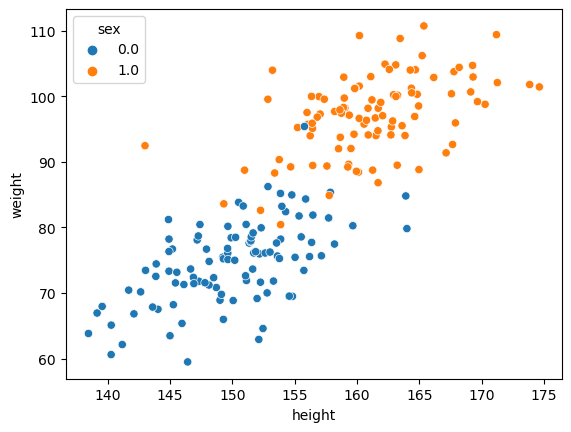

In [8]:
(
    sns.scatterplot(
        df_sim,
        x="height", 
        y="weight",
        hue="sex"
    )
)

In [9]:
df_sim[df_sim["sex"] == 0]["weight"].mean() - df_sim[df_sim["sex"]==1]["weight"].mean()

-22.334980914483978

### Test generative model

In [10]:
sex_codes, sex_names = pd.factorize(df_sim["sex"])
heights = df_sim["height"].values
weights = df_sim["weight"].values

In [11]:
sex_codes

array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1,
       1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0,
       0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0,
       0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1,
       1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0,
       0, 1], dtype=int64)

In [13]:
coords = {"sex": sex_names}
with pm.Model(coords=coords) as m_1:
    
    alpha = pm.Normal("alpha", 60, 5, dims="sex")
    
    w_mu=pm.Deterministic("w_mu", alpha[sex_codes])
    w_sigma=pm.Exponential("w_sigma", lam=1/10)
    
    W = pm.Normal(
        "W",
        mu=w_mu,
        sigma=w_sigma,
        observed=weights
    )
    
    idata = pm.sample_prior_predictive()
    idata.extend(pm.sample(chains=4, draws=1000))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, w_sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 24 seconds.


In [14]:
az.summary(idata.posterior, var_names=["alpha"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha[0.0],74.513,0.625,73.341,75.662,0.009,0.006,5266.0,2856.0,1.0
alpha[1.0],96.477,0.630,95.239,97.590,0.010,0.007,4190.0,2969.0,1.0


In [37]:
sex_codes, sex_names = pd.factorize(df_how["sex"])
heights = df_how["height"].values
weights = df_how["weight"].values

## Splines

In [1]:
from patsy import dmatrix

In [9]:
df_bloom = (
    pd.read_csv(DATA_PATH / "cherry_blossoms.csv", sep=",")
    .dropna(subset="doy")
)

In [10]:
df_bloom.head()

,year,doy,temp,temp_upper,temp_lower
11,812,92.0,NaN,NaN,NaN
14,815,105.0,NaN,NaN,NaN
30,831,96.0,NaN,NaN,NaN
50,851,108.0,7.38,12.1,2.66
52,853,104.0,NaN,NaN,NaN


### B-spline matrix

In [31]:
num_knots = 15
knot_list = np.quantile(df_bloom["year"], np.linspace(0, 1, num_knots))

B = dmatrix(
    "bs(year, knots=knots, degree=3, include_intercept=False) - 1",
    data={
        "year": df_bloom["year"],
        "knots": knot_list[1:-1]
    }
)

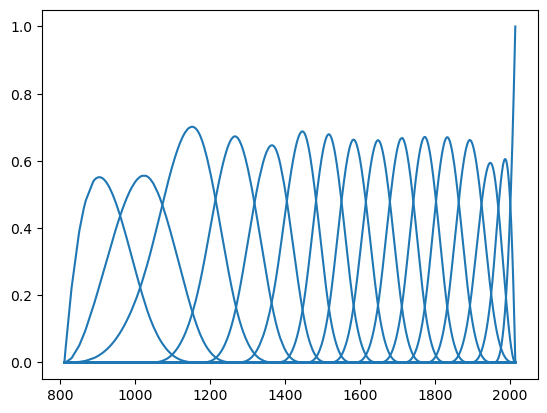

In [32]:
fig, ax = plt.subplots()
for i in range(B.shape[1]):
    ax.plot(df_bloom["year"], B[:, i], color="C0")    